# Import-Export Analysis
To model the wheat price on the danish market, it might be valuable
to include features that give an indication of supply and demand. 
The assumption is, that the quantities of imported and exported wheat
can give such indications. 

The idea is to identify the countries with the largest import
of wheat from Denmark and then identify from what other countries they
import wheat. With data on wheat production in those countries, it
might be possible to model how much wheat will hit the market in the future. 

#### Underlying assumption:
- Countries import majority of wheat from a few exporters
- Those countries are mostly the same through the years


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
sns.set_context("talk")

df = pd.read_csv("../grain-price-data/wheat_import_export_EU.csv")
df.head()

,PERIOD,REPORTER,PARTNER,PRODUCT,FLOW,INDICATORS,Value,Flag and Footnotes
0,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),WORLD,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,34850860,NaN
1,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),WORLD,Wheat and meslin(1988-2500),EXPORT,QUANTITY_IN_100KG,10476666,NaN
2,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AD,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,:,NaN
3,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AD,Wheat and meslin(1988-2500),EXPORT,QUANTITY_IN_100KG,:,NaN
4,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AE,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,:,NaN


The dataset contains yearly data on all EU countries import and export of wheat from 2000 to 2020.
First we take a look at wheat export of 2019 from denmark:

In [2]:
# Select DK exports and drop rows without data and convert 'Value' column to numeric
exports_DK = df.loc[(df['REPORTER'] == 'DENMARK') & ( df['FLOW'] == 'EXPORT')]
exports_DK = exports_DK.drop(exports_DK[(exports_DK.Value == ':') | (exports_DK.Value == '0')].index)
exports_DK['Value'] = pd.to_numeric(exports_DK['Value'])

# get a list of the years that is easy to iterate through
periods = exports_DK['PERIOD'].unique()

# get exports of 2019 and group them by import country
exports_DK_2019 = exports_DK.loc[exports_DK['PERIOD'] == periods[-1]]
exports_DK_2019 = exports_DK_2019.groupby('PARTNER')['Value'].sum()
exports_DK_2019 = exports_DK_2019.sort_values(ascending=False)[1:]
exports_DK_2019


PARTNER
ES    3042527
SE     838205
NL     819636
FR     639093
LT     420075
IE     280094
DE     276666
PL     144652
FI     111009
IS     109237
GB      77294
NO      70137
BE      39426
LV       2216
AT        260
FO          7
CY          4
GL          4
Name: Value, dtype: int64

Spain is by far the largest importer of wheat from Denmark in 2019. The result includes the aggreate value for world, but Eurostat cautions that it is not computed when data is pulled, but stored in the database, so it might not be completely accurate.

Let's see how the importing countries are distributed in terms of the quantity:

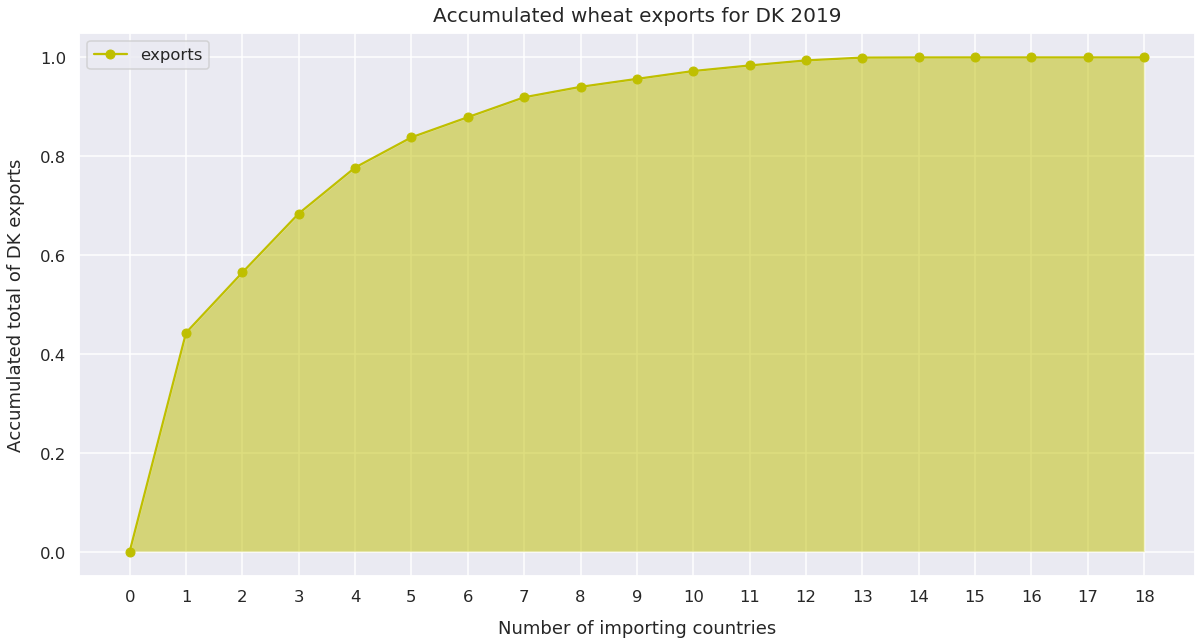

In [7]:
exports_cumulative = (exports_DK_2019.astype(int).cumsum() / 
                      exports_DK_2019.astype(int).sum()).values
exports_cumulative = np.insert(exports_cumulative, 0 ,0)


plt.title("Accumulated wheat exports for DK 2019", y=1.01, fontsize=20)
plt.ylabel("Accumulated total of DK exports", labelpad=15)
plt.xlabel("Number of importing countries", labelpad=15)
plt.rcParams['figure.figsize'] = [20,10]
plt.xticks(range(len(exports_cumulative)))
plt.plot(exports_cumulative,'yo-', label='exports')
plt.fill_between(range(len(exports_cumulative)),exports_cumulative,facecolor='y', alpha=0.5)

plt.legend()
plt.show()

For 2019 it appears that five importing countries account for more than 80% of the total wheat exports from DK.

Let's see how much the top imports account for during the other years:

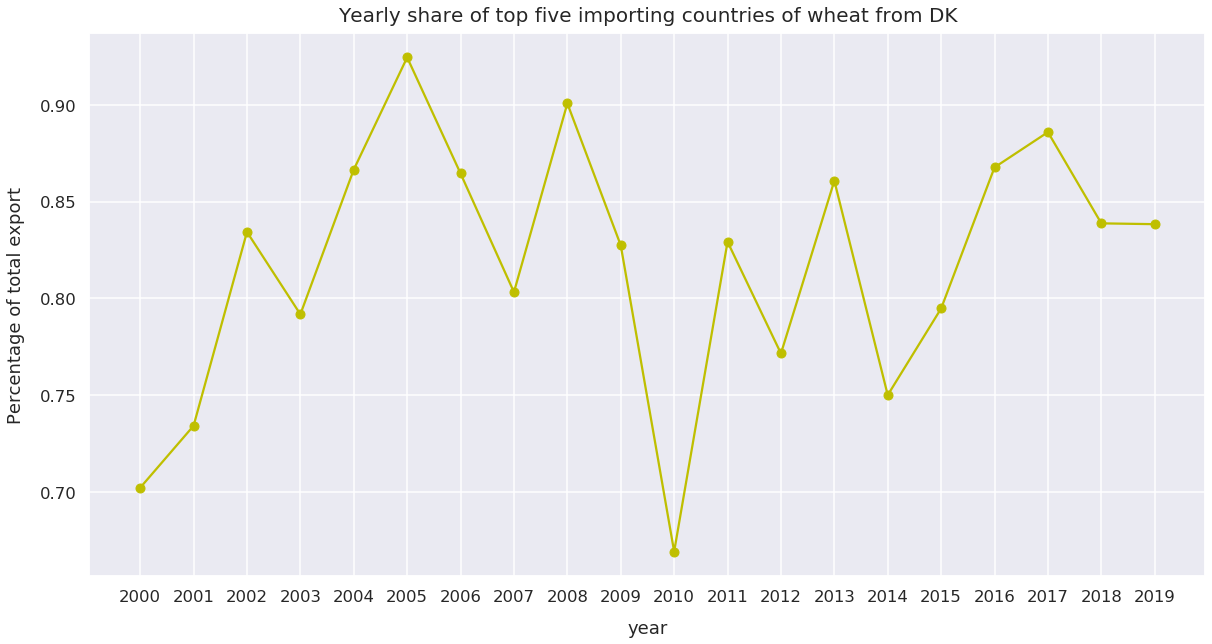

In [4]:


numberOfImporters = 5
topImporterShare = []
for i in periods:
    exports_DK_year = exports_DK.loc[exports_DK['PERIOD'] == i]
    exports_DK_year = exports_DK_year.groupby('PARTNER')['Value'].sum()
    # sort and leave out the aggregated world value
    exports_DK_year = exports_DK_year.astype(int).sort_values(ascending=False)[1:]
    total_exports = exports_DK_year.astype(int).sum()
    top_exports = exports_DK_year[:numberOfImporters].sum()
    export_percentage = top_exports / total_exports
    topImporterShare.append(export_percentage)
        
plt.title("Yearly share of top five importing countries of wheat from DK", y=1.01, fontsize=20)

plt.rcParams['figure.figsize'] = [20,10]
ax = plt.axes()
plt.ylabel("Percentage of total export", labelpad=15)
plt.xlabel("year", labelpad=15)
years = list(map(lambda x : int(x + 2000), list(range(len(periods)))))
ax.set_xticks(years)
plt.plot(years, topImporterShare, 'yo-', label='exports')
plt.show()


The five top importers account for more than 70% of danish exports for all years except 2010. Looking at the top six importers, it is over 75% and 2010 is over 70%.

Let's take a look at the top importers over the years:


In [5]:
exports_DK_all = exports_DK.loc[exports_DK['PERIOD'].isin(periods[:])]  
exports_DK_all = exports_DK_all.groupby(['PERIOD','PARTNER']).sum().sort_values(['PERIOD','Value'],ascending=False)
print(exports_DK_all.groupby('PERIOD').head(7).to_string())


                           Value  Flag and Footnotes
PERIOD         PARTNER                              
Jan.-Dec. 2019 WORLD     6870543                 0.0
               ES        3042527                 0.0
               SE         838205                 0.0
               NL         819636                 0.0
               FR         639093                 0.0
               LT         420075                 0.0
               IE         280094                 0.0
Jan.-Dec. 2018 WORLD     4866702                 0.0
               GB        1797930                 0.0
               DE         785377                 0.0
               IE         683963                 0.0
               SE         409791                 0.0
               NL         404738                 0.0
               ES         340275                 0.0
Jan.-Dec. 2017 WORLD     9031023                 0.0
               ES        3571209                 0.0
               NL        2130559              

Top importers seem to be somewhat the same from year to year, but changes over the years lead to some different importers over time. 

Considering that the largest importers of the most recent years are probably also the most likely in the upcoming year, it might be worth weighting the imported amount based on year.

For this I will use exponential weighting, such that latest year has weight of 1, then a, a^2, a^3 and so on. The weights are normalized a^ / 1-a

In [6]:
a = 0.90
weights = list(a ** i for i in range( len(periods)))
weights = list(reversed(weights))

#print(weights)
result = []   
numberOfYears = len(periods) 
for i in range(numberOfYears ):
    exports_DK_year = exports_DK.loc[exports_DK['PERIOD'].isin([periods[i]])]  
    exports_DK_year = exports_DK_year.groupby(['PARTNER']).sum().sort_values('Value',ascending=False)
    # percentage of import multiplied by the weight
    exponent = (-1 * (i-numberOfYears)) 
    exports_DK_year = (exports_DK_year['Value'][1:] / exports_DK_year['Value'][0]) * (a**exponent/(1-a)) #

    result.append(exports_DK_year)
    
result= pd.concat(result)
result = result.groupby('PARTNER').sum().sort_values(ascending=False)
result[:10]


PARTNER
ES    15.768401
DE    15.247473
NL    13.209207
GB     6.820166
IE     5.302631
FR     4.291896
SE     3.869598
NO     2.811199
PL     2.101972
IS     1.545112
Name: Value, dtype: float64

The top five importers are Spain, Germany, Netherlands, Great Britain and Ireland. Since brexit took effect early this year, British imports of EU commodities will presumably decrease in the future.   

Next, let's find out what countries export to these five countries.